# FINAL PROJECT

**COMMENTS**
* 70/70 Very nicely done.
* I didn't see that you used LaTex anywhere? I had offered 5 extra points if you did. Frankly, I don't think it will make a difference for your final grade, but I was just checking.


In the final project, you will create a closed loop system for an SBML model.
Start by selecting a model from the [BioModels Curated branch](https://www.ebi.ac.uk/biomodels/search?query=*%3A*+AND+curationstatus%3A%22Manually+curated%22&domain=biomodels).)
You don't have to restrict yourself to thoses models, but you'll find that the curated BioModels are fairly easy to reproduce.) You'll find a paper associated with each model.

1. **Specify the requirements for the control system.** (10 pt) After reading the paper for the model, propose a chemical species for the control output
and an operating point for it. You should also indicate the desired
operating characteristics such as settling time and overshoot.
Justify this in terms of the potential value of controlling
the chemical species and why the particular operating point makes sense.
1. **Determine the control input you will use**. (10 pt) This will require evaluating the DC gain of
of candidate control inputs on chemical species that are the control outputs.
1. **Design the control system**. (15 pt) You will specify a controller and possibly a filter.
You will select the parameters of the elements based on the poles and DC gains implied by
the operating characteristics in (1).
1. **Evaluate your design.** (25 pt) You will construct a simulation testbed in which the
SBML model is regulated by your control architecture.
You should evaluate the effects of disturbances and noise.
1. **Discuss trade-offs.** (10 pt) Discuss trade-offs in the selection of parameter values in your design.
This should consider the impact of parameter values on the closed loop transfer functions.

You will receive 5 extra points if you use LaTex for your mathematical analyses.

**All students will present their projects during the last week of class.**
This is an ungraded presentation intended to give you early feedback on your work.

# Preliminaries

In [1]:
!pip -q install controlSBML
import controlSBML as ctl
import control
from controlSBML.util import makeSimulationTimes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import tellurium as te
import sympy

     |████████████████████████████████| 398 kB 8.2 MB/s 
     |████████████████████████████████| 8.8 MB 37.4 MB/s 
     |████████████████████████████████| 154 kB 40.4 MB/s 
     |████████████████████████████████| 485 kB 42.2 MB/s 
     |████████████████████████████████| 6.8 MB 24.9 MB/s 
     |████████████████████████████████| 121 kB 36.7 MB/s 
     |████████████████████████████████| 428 kB 36.1 MB/s 
     |████████████████████████████████| 342 kB 42.3 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 561 kB 39.4 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 131 kB 17.5 MB/s 
     |████████████████████████████████| 80 kB 3.6 MB/s 
     |████████████████████████████████| 133 kB 8.2 MB/s 
     |████████████████████████████████| 106 kB 52.2 MB/s 
     |████████████████████████████████| 250 kB 44.9 MB/s 
     |████████████████████████████████| 103 kB 63.9 MB/s 
     |████████████████

# Helpful Hints

## LaTex Basics

1. All LaTex appears between dollar signs (``$``)
1. Subscripts: $x_2$
1. Superscript: $x^2$
1. Summation: $\sum_{n=0}^{\infty} e^{nt}$
1. Derivatives: $\dot{x}(t)$
1. Bold: ${\bf A}$
1. Fractions: $\frac{a}{b}$

## Closed Loop Transfer Functions

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

# 1. Specify Requirements

For this project, I started by looking at the work of Teusink, Walsh, van Dam, and Westerhoff in their 1998 paper: The danger of metabolic pathways with turbo design.

https://www.ebi.ac.uk/biomodels/BIOMD0000000253#Overview

In this paper, Teusink et al. discuss the notion of turbo design biological systems and create a model for their behavior. Turbo design pathways are biological pathways that require ATP to be expended in order to begin them but that ultimtely result in a net positive amount of ATP after the entire pathway's reactions have been completed. These kinds of systems are very prevalent in things such as glycolysis due to the fact that they are energetically favorable and thus likely to occur spotaneously in biological environments. However, the paper's authors note that turbo design systems are incredibly sensitive to their initial conditions, in that a high intial ATP concentration can  in actually result in all the ATP being consumed before the pathway reaches the reactions that generate it once more. When this occurs, the ATP is consumed but the system fails to reach its endpoint. Teusink et al. provide a model for this behavior in a simple glygolytic system in Saccharomyces cerevisiae (also known as Brewer's Yeast).

In this system, a controller that could regulate the input of reagents into the turbo glycolysis pathway could help combat the sensitivity of the turbo design by adjusting for the initial sudden consumption and later sudden generation of ATP.

To this end, a PID controller could be applied to the Teusink et al. paper's glycosis model with keto-D-fructose 1,6-bisphosphate (Fru16P2) as its system input and ATP as its system output. The operating point for this controlled system could be set to 3mmol, as that is a value measured within cellular systems for which the turbo design system consumes its initial ATP before re-generating it (see part 4).

For this control system, overshoot is not a significant issue, as ATP does not cause adverse affects unless its concentration exceeds the norm by an extreme degree (several orders of magnitude). However, most biological systems rely on a steady inflow of ATP from relatively quick and stable glycolytic systems. As such, the settling time for this controlled system should be low, within 5 seconds, and any oscillations in the final concentration of ATP must be neglegible relative to the operating point.

**COMMENTS**
* Very nice background and justification.

# 2. Determine the Control Input

From a technical perspective, Fru16P2 would be a reasonable input to use to the system for control because it is an early intermediate in the yeast glycolysis process with a significant DC gain (~2.4) with respect to ATP.

In [2]:
BIOMD = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000253.2?filename=BIOMD0000000253_url.xml"
input_string = "Fru16P2"
output_string = "ATP"
ctlsb = ctl.ControlSBML(BIOMD, input_names=[input_string], output_names=[output_string])
ctlsb.makeTransferFunction(time=1)

TransferFunction(array([18.18181745,  5.70440441]), array([1.        , 8.31955087, 2.41679775]))

In [3]:
ctlsb.makeTransferFunction(time=1).dcgain()

2.3603151751225897

In addition to being a good technical target with which to control ATP, Fru16P2 has a major theoretical advantage over other choices of input as well.

Fru16P2 can be controlled with less risk to the cellular system than glucose (the other obvious candidate for the control input), as it does not display the same degree of toxicity. In high concentrations, glucose readily cross links with nearby proteins in a manner reminicent of formaldehyde. Typical biological concentrations of glucose render this effect neglegible, but PID control systems can often introduce large and highly varying concentrations of their system input in order to adjust for sudden displacements in the control target. This could, in theory, result in a dangerous concentration of glucose. For the sake of minimizing this effect, another system input, such as Fru16P2 should be chosen.

**COMMENTS**
* Nicely done.

# 3. Design the Control System

For this system, a controller can be designed to adjust for the time-delayed fluctuations in ATP and create a closed loop DC gain from reference to ATP output of close to 1. Given that one of our goals is to control the DC gain of the system, a PID controller would be a more effectuve choice that a Full State controller, as the later cannot easily eliminate bias.

To help combat the effect of noise on the controller and system, a simple exponential filter can be added in between the system output and controller input that helps attenuate noise over time.

For this controlled system: stability, low oscillations, and low bias are the priority. As such, the poles of the transfer function from reference to output at the simulation's endpoint should include no positive real terms or large imaginary terms and the transfer function's DC gain should be within 0.01 of 1. Poles with no positive terms will ensure stability in the concentration of ATP,  poles with no large imaginary components will ensure that the system does not experience large long term oscillation, and a DC gain close to one will ensure that the bias for the system is small. Due to the sensitivity of this system with respect to ATP, the DC gain requirement is particularly strict here.

In order to tune the parameters of the PID controller the following code was used which plots the output of a closed loop through a parameter sweep of kp and ki values:

In [4]:
#@title
BIOMD = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000253.2?filename=BIOMD0000000253_url.xml"
#ctlsb = ctl.ControlSBML(BIOMD)
input_string = "Fru16P2"
output_string = "ATP"
ctlsb = ctl.ControlSBML(BIOMD, input_names=[input_string], output_names=[output_string])

In [5]:
#@title
def evaluateDesign(kp, ki, kd, kf=-1, system_model=BIOMD, input_name=input_string, 
                   output_name=output_string, reference=5, noise_values=[0.05, 20.0], 
                   disturbance_values=[0.05, 2.0], simulation_times=[0,40,100], 
                   plot_y_limits=None):
  """
  This function evaluates the effect of a given set of PID control parameters on a
  user-provided SISO model in a closed-loop system by plotting the reference 
  input, system input, and system output in response to a given reference value.

  Parameters
  ----------
  kp: A float containing the proportional control constant for a PID controller
  ki: A float containing the integral control constant for a PID controller
  kd: A float containing the derivative control constant for a PID controller
  kf: A float containing the exponential value to be used in a filter for the 
  closed loop system. Defaults to -1.
  system_model: An SBML model describing the system to be controlled in the closed 
  loop.
  input_name: A string containing the name of the control input in the system.
  output_name: A string containing the name of the control output in the system.
  reference: A numeric value containing the reference input used to control the 
  system. Default to 1.
  noise_values: A list containing, in order, the magnitude and the frequency of the 
  simulated output noise in the closed loop system, represented as floats. 
  Defaults to [0.05, 20].
  disturbance_values: A list of containing, in order, the magnitude and the 
  frequency of the simulated control value disturbance in the closed loop system, 
  represented as floats. Defaults to [0.05, 2].
  simulation_times: A list of numeric values containing, in order, the starting 
  time, ending time, and number of time points per unit of time to be used in the 
  simulation of the closed loop system. Defaults to [0, 40, 100].
  plot_y_limits: A list of numeric values containing, in order, the lower and 
  upper bound of y-axis values to be displayed on the plot. If None, uses 
  pyplot's default axis scaling. Defaults to None.

  Returns
  -------
  closed_loop_analysis: A list containing three objects.
  At index 0, a pyplot figure object showing the reference, system input, and system output over time.
  At index 1, the TimeResponseData object created by running a simulation of the closed loop system. 
  And at index 2, the InterconnectedSystem object containing the closed loop system.
  """
  ### Creating objects to be included in the closed loop
  # Creating NonlinearIOSystem object for the biomodel system of interest
  ctlsb = ctl.ControlSBML(system_model, input_names=[input_name], output_names=[output_name])
  system = ctlsb.makeNonlinearIOSystem("system")
  # Creating factory to generate PID controller and filter objects
  factory = ctl.IOSystemFactory()
  controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd)
  filter = factory.makeFilter("filter", constant=kf)
  # Creating generators for disturbance and noise
  noise = factory.makeSinusoid("noise", noise_values[0], noise_values[1])
  disturbance = factory.makeSinusoid("disturbance", disturbance_values[0], disturbance_values[1])
  # Creating Adder objects to calculate error, introduce disturbance, and introduce noise
  sum_output_noise = factory.makeAdder("sum_output_noise")
  sum_control_disturbance = factory.makeAdder("sum_control_disturbance")
  sum_reference_filter = factory.makeAdder("sum_reference_filter")

  ### Assembling closed loop with interconnects
  # Creating system input/output name strings
  system_input = "system.%s" % input_name
  system_output = "system.%s" % output_name
  # Creating interconnect object
  closed_loop = control.interconnect(
    [noise, disturbance, sum_output_noise, sum_control_disturbance, sum_reference_filter, system, filter, controller], 
    connections=[
      ['controller.in', 'sum_reference_filter.out'],      # passing error into controller
      ['sum_control_disturbance.in1', 'controller.out'],  # passing controller output into control/disturbance adder
      ['sum_control_disturbance.in2', 'disturbance.out'], # passing disturbance output into control/disturbance adder
      [system_input,   'sum_control_disturbance.out'],    # passing control with disturbance to system input
      ['sum_output_noise.in1', system_output],            # passing system output into output/noise adder
      ['sum_output_noise.in2', 'noise.out'],              # passing noise output into output/noise adder
      ['filter.in',     'sum_output_noise.out'],          # passing output with noise into filter input
      ['sum_reference_filter.in1', '-filter.out'],        # passing inverted filter output into reference/filter adder
    ],
    inplist=["sum_reference_filter.in2"],
    outlist=["sum_reference_filter.in2", system_input, system_output],
  )

  ### Running simulation of closed loop control system
  X0 = ctl.makeStateVector(closed_loop)
  #print(ctlsb.makeTransferFunction())
  simulation_times = ctl.makeSimulationTimes(simulation_times[0], simulation_times[1], simulation_times[2])
  result = control.input_output_response(closed_loop, T=simulation_times, U=reference, X0=X0)

  ### Creating plot of reference and system values
  # Creating figure object to return
  fig = plt.figure()
  plt.plot(result.t, result.outputs[0].flatten())
  plt.plot(result.t, result.outputs[1].flatten())
  plt.plot(result.t, result.outputs[2].flatten())
  plt.legend(["Reference", input_name, output_name])
  plt.title("Closed Loop Response to Input of " + str(reference) +  " With kp=" + str(kp) + ", ki=" + str(ki) + ", and kd=" + str(kd))
  plt.xlabel("Time")
  plt.ylabel("Closed Loop State Value")
  if plot_y_limits != None:
    plt.ylim(plot_y_limits)
  plt.close()
  
  # Returning plot, simulation results, and closed_loop
  closed_loop_analysis = [fig, result, closed_loop]
  return closed_loop_analysis

#Tests
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
test_results = evaluateDesign(0,2,0, system_model=BIOMD823 ,simulation_times=[0,55,100], input_name="pAkt", output_name="pDEPTOR")
# Check that the function returns a figure object
assert(type(test_results[0]) == type(plt.figure()))
# Check that the function returns a TimeResponseData object of results, with the expected start and end times
assert(test_results[1].t[0] == 0.0)
assert(test_results[1].t[-1] == 55.0)
# Check that the function returns an InterconnectedSystem object with the expected components
assert(test_results[2].syslist[0].name == 'noise')
assert(test_results[2].syslist[1].name == 'disturbance')
assert(test_results[2].syslist[7].name == 'controller')
print("Tests Passed!")

Tests Passed!


<Figure size 432x288 with 0 Axes>

In [6]:
results_grid = np.ndarray(shape=(4,4), dtype=list)
k_props = [1, 5, 10, 15]
k_ints = [1, 2, 3, 4]
for k_prop_ind in range(4):
  for k_int_ind in range(4):
    results_grid[k_prop_ind, k_int_ind] = evaluateDesign(k_props[k_prop_ind], k_ints[k_int_ind], 0, reference=3, plot_y_limits=[0,10], simulation_times=[0,20,20], input_name="HMP")[0]

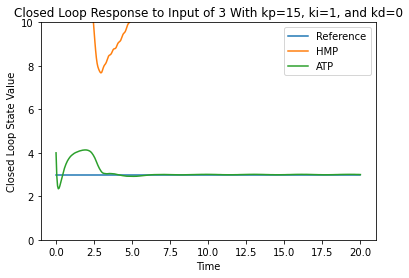

In [7]:
results_grid[3,0]

Inspecting the above array of plots, we find that a kp of 15 and a ki of 1 yields a fast settling time (~2.7 seconds) with minimal oscillations and no noticable bias. Since these design parameters result in the desired behavior, further modifications to the design such as the use of derivative control were not considered due to the trade offs inherent in their inclusion (see part 5).

**COMMENTS**
* Nicely done.

# 4. Evaluate the Design

In the absence of control, the modelled system displays the following behaviors, with ATP being rapidly consumed before being steady generated unless it is fully consumed, in which case it fails to generate ATP at all.

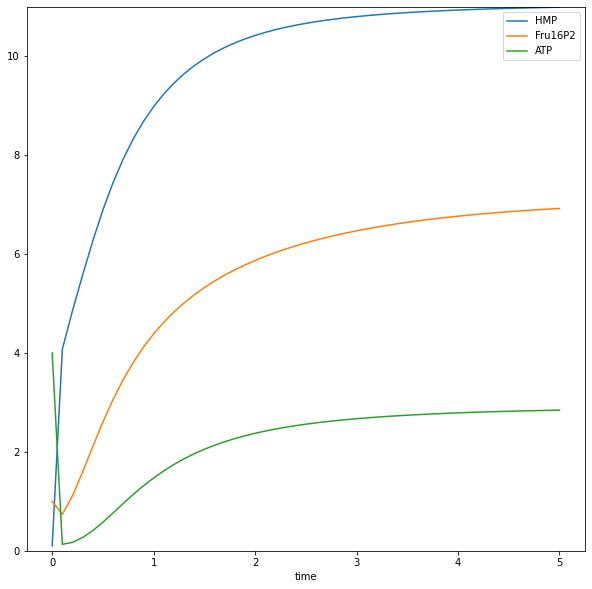

In [8]:
#@title
ctlsb.plotTrueModel()

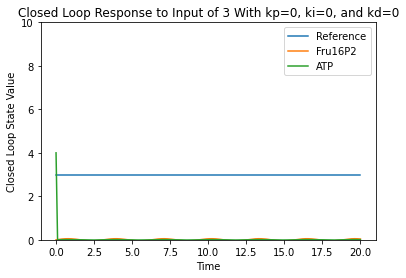

In [9]:
#@title
results = evaluateDesign(0,0,0, simulation_times=[0,20,10], plot_y_limits=[0,10], reference=3)
results[0]

With a PID controller with a proportional control constant of 15 and an integral control constant of 1, the system displays the following behavior:

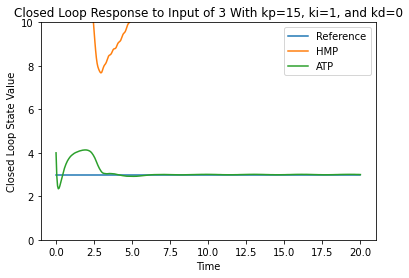

In [20]:
evaluateDesign(15, 1, 0, reference=3, plot_y_limits=[0,10], simulation_times=[0,20,20], input_name="HMP")[0]

This closed loop system settles faster than the maximum acceptable settling time (5 sec), has extremely small oscillations, and no discernible bias. Given that the closed loop system includes noise and disturbance, this closed loop system can also be observed to be capable of attenuating noise.

When the noise and disturbance are increased by an order of magnitude, the response becomes the following:

**COMMENTS**
* Looks reasonable for your reference. I tried 4 as well, and although settling times are longer, it has no bias.

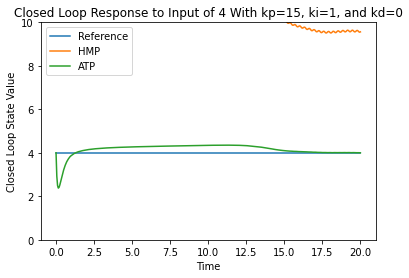

In [21]:
evaluateDesign(15, 1, 0, reference=4, plot_y_limits=[0,10], simulation_times=[0,20,20], input_name="HMP")[0]

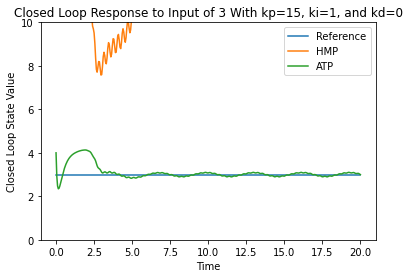

In [11]:
evaluateDesign(15, 1, 0, reference=3, plot_y_limits=[0,10], simulation_times=[0,20,20], input_name="HMP", noise_values=[0.5,20], disturbance_values=[0.5,2])[0]

Despite the fact that the system includes noise and disturbance with an amplitude of 0.5, the system was able to settle to the operating point with neglegible oscillation and no bias in the long term value of ATP.

All these qualitative factors together suggest that this controller design fits all of the system's requirements. To obtain quantitive assurances of the controlled system's effectiveness and to better understand its long term behavior, the transfer functions of the output with respect to the reference and  to the noise were generated as follows:

In [12]:
#@title
def plotTFs(Gs, kp=15, ki=1, kd=0, times=ctl.makeSimulationTimes(0, 20, 10), ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    kp: float
    ki: float
    kd: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
    Fs = 1
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=times, U=1)
        plt.plot(result.t.flatten(), result.y.flatten())
    # Refine plots
    plt.legend(list(tf_dct.keys()))
    xmax = max(result.t.flatten())
    plt.plot([0, xmax], [0, 0], linestyle="--", color="black")
    plt.plot([0, xmax], [1, 1], linestyle="--", color="grey")
    plt.ylim([-5, 5])
    title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
    plt.title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, kp=10, ylim=[0, 3], title="Example", is_plot=False)
assert(len(dct) == 4)
assert("TransferFunction" in str(type(dct["HRYs"])))
print("OK!")

OK!


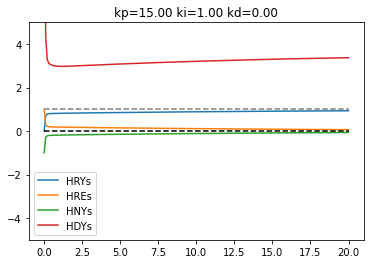

In [13]:
tf_dict = plotTFs(ctlsb.makeTransferFunction())

In [14]:
tf_dict["HRYs"]

TransferFunction(array([  18.26773373,  222.40361297,  847.03740233, 1041.94005668,
         65.76359629,    0.        ]), array([1.00000000e+00, 3.54716783e+01, 3.27201496e+02, 1.11201218e+03,
       1.27916098e+03, 6.57635963e+01, 0.00000000e+00]))

In [15]:
tf_dict["HRYs"].poles()

array([-23.43537396+0.j,  -6.06067472+0.j,  -3.38043506+0.j,
        -2.54129758+0.j,  -0.053897  +0.j,   0.        +0.j])

The above transfer function from the reference to the output shows a DC gain of 1, and contains poles with strictly real, negative values. Assuming that this linearization is representative of the long term system behavior, The fact that the DC gain is precisely 1 suggests that the system will have no noticable bias after it settles and the fact that all the poles are negative and real suggests that the reference values for Fru16P2 will have a stable, non-oscillatory effect on the long-term value of the output ATP.

In [16]:
tf_dict["HNYs"]

TransferFunction(array([ -1.        ,  -8.6019723 , -15.40197801,   0.        ]), array([ 1.        , 26.86970603, 80.66705148,  4.26981497]))

In [17]:
tf_dict["HNYs"].dcgain()

0.0

The above transfer function from the noise to the output shows a DC gain of 0. Assuming that this linearization too is representative of the long term behavior of the controlled system, this suggests that an increase in the noise of the measured ATP will have no long-term effect on the value of ATP as the controlled system stabilizes.

In [18]:
tf_dict["HDYs"]

TransferFunction(array([ 15.        , 130.02958451, 239.63164251,  15.40197801,
         0.        ]), array([ 1.        , 26.86970603, 80.66705148,  4.26981497,  0.        ]))

And lastly, the above transfer function from the disturbance to the output shows a DC gain of approximately 3. Assuming for the final time that this linearization is representative of the long term behavior of the controlled system, this highlights the greatest weakness of this controlled system. This system is noticably susceptible to increases in disturbance. While this did not pose a significant issue in our above plots due to the system's relative robustness overall, it should be nonetheless be noted that the system's controller will need to be implemented with an eye towards minimizing disturbance. In practice, this is not likely to be an issue, as Fru16P2 is hardly ever generated outside the reaction pathway being controlled in this system, but it nonetheless remains a potential point of failure that will need to be closely monitored should this controller ever be implemented.

# 5. Discuss Trade-offs

In designing this controlled system, priority was given to a fast settling time and a low bias. In pursuit of this goal, a relatively high degree of proportional and a noticable degree of integral control was introduced to the system. As a result, the system's overshoot is very significant, to the point of being 33% higher than the operating point for the entire time before the system settles. However, this came with the benefit of a DC gain of 1 and no imaginary poles due to integral's control's ability to eliminate bias and proportional control's ability to conteract offsets.

 Derivative control (or lower integral control) could have been used to counteract the noticable overshoot in this control system, but doing so would have come at the cost of a slower settling time and less resistance to noise. In this biological system, an excess of ATP poses little issue so long as it does not reach concentrations several orders of magnitude higher than expected (thereby crowding the environment). Since settling time is a major requirement for this controller while overshoot is not, derivative control was not significantly considered in the controller's design.

 As a result of these tradeoffs, the final controller design that met the requirements laid out in this project was a PI controller with high proportional control and moderate integral control.

